<a href="https://colab.research.google.com/github/Jean-KOUAGOU/AIMS-MCFDM2019/blob/master/Copy_of_AMMI_EXPRL_Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!git clone https://github.com/rlgammazero/mvarl_hands_on.git > /dev/null 2>&1

In [0]:
import sys
sys.path.insert(0, './mvarl_hands_on/exploration')

In [0]:
import numpy as np
from riverswim import RiverSwim
import cvxpy as cp
import matplotlib.pyplot as plt
%matplotlib inline

# Finite-Horizon MDPs
We consider finite horizon problems with horizon $H$. For simplicity, we consider MDPs with stationary transitions and rewards, ie these functions do not depend on the stage ($p_h =p$, $r_h=r$ for any $h \in [H]$).

The value of a policy or the optimal value function can be computed using *backward induction*.


Given a deterministic (non-stationary) policy $\pi = (\pi_1, \pi_2, \ldots, \pi_H)$, backward induction applies the Bellman operator defined as
$$
V_h^\pi(s) = \sum_{s'} p(s'|s,\pi_h(s)) \left( r(s,\pi_h(s),s') + V_{h+1}^\pi(s')\right)
$$
where $V_{H+1}(s) = 0$, for any $s$. 

In [37]:
env = RiverSwim(6)
H = 10
print("Reward matrix: ", env.R.shape)
print(env.R)
print()
print("Transition matrix: ", env.P.shape)
print("Transitions probabilities for state s_1:")
print(env.P[1])

print(env.P[0, 1, 1])

Reward matrix:  (6, 2)
[[0.005 0.   ]
 [0.    0.   ]
 [0.    0.   ]
 [0.    0.   ]
 [0.    0.   ]
 [0.    1.   ]]

Transition matrix:  (6, 2, 6)
Transitions probabilities for state s_1:
[[1.   0.   0.   0.   0.   0.  ]
 [0.05 0.6  0.35 0.   0.   0.  ]]
0.6


# Backward induction (aka Value Iteration)

In [0]:
def backward_induction(P, R, H):
    """
        Parameters:
            P: transition function (S,A,S)-dim matrix
            R: reward function (S,A)-dim matrix
            H: horizon

        Returns:
            The optimal V-function
            The optimal policy
    """
    S, A = P.shape[0], P.shape[1]
    policy = np.zeros((H, S), dtype=np.int)
    V = np.zeros((H + 1, S))
    for h in reversed(range(H)):
        for s in range(S):
            """ 
            Here, we compute V^*(h, s) using the Bellman optimality equation:

            V[h, s] = max_a  R[s, a] + sum_{s'} P[s, a, s']*V[h+1, s']
            """
            for a in range(A):
                tmp = np.dot(P[s, a], R[s, a] + V[h + 1])
                if (a == 0) or (tmp > V[h, s]):
                    policy[h, s] = a
                    V[h, s] = tmp
    return V, policy

def policy_evaluation(P, R, H, policy):
    """
        Parameters:
            P: transition function (S,A,S)-dim matrix
            R: reward function (S,A)-dim matrix
            H: horizon
            policy: policy (H,S)-dim matrix

        Returns:
            The V-function of the given policy
    """
    S, A = P.shape[0], P.shape[1]
    V = np.zeros((H + 1, S))
    for h in reversed(range(H)):
        for s in range(S):
            """ 
            Here, we compute V^pi(h, s) using the Bellman equation for the policy pi:

            a = policy[h,s]
            V[h, s] =  R[s, a] + sum_{s'} P[s, a, s']*V[h+1, s']
            """
            a = policy[h,s]
            # complete the policy evalution here
            V[h, s] = R[s, a] + P[s,a,:].dot(V[h+1,:])
    return V

Compute solution

In [39]:
Vstar, POLstar = backward_induction(env.P, env.R, H)

print("Optimal policy")
print(np.round(Vstar))

print(POLstar)

#to test the implementation
V_policy = policy_evaluation(env.P, env.R, H, POLstar)

Optimal policy
[[0. 1. 1. 2. 4. 5.]
 [0. 0. 1. 2. 3. 5.]
 [0. 0. 1. 2. 3. 4.]
 [0. 0. 1. 1. 3. 4.]
 [0. 0. 0. 1. 2. 3.]
 [0. 0. 0. 1. 2. 3.]
 [0. 0. 0. 0. 1. 3.]
 [0. 0. 0. 0. 1. 2.]
 [0. 0. 0. 0. 0. 2.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0.]]
[[1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [0 1 1 1 1 1]
 [0 1 1 1 1 1]
 [0 0 1 1 1 1]
 [0 0 0 1 1 1]
 [0 0 0 0 1 1]
 [0 0 0 0 0 1]]


In [35]:
print(np.abs(V_policy-Vstar).sum())

7.16093850883226e-15


In [44]:
S, A = env.R.shape # number of states and actions
Phat = np.zeros((S,A,S))
Rhat = np.zeros((S,A))

N_sa = np.zeros((S,A)) # number of visits to each state-action
N_sas = np.zeros((S,A,S)) 
S_sa = np.zeros((S,A)) # sum of rewards obtained when visiting each state-action

# Interact with the system
nb_episodes = 200
# Loop over episodes
for ep in range(nb_episodes):
  state = env.reset()
  for h in range(H):
    action = np.random.choice(A)
    next_state, reward, done, _ = env.step(action)
    # Update estimates
    N_sa[state, action] += 1
    N_sas[state, action, next_state] += 1
    S_sa[state, action] += reward

    Rhat[state, action] = S_sa[state, action]/N_sa[state, action]
    Phat[state, action, :] = N_sas[state, action, :]/N_sa[state, action]
    state = next_state

print(Rhat)
print(env.R)


beta_r = np.zeros((S,A))
for s in range(S):
  for a in range(A):
    n = max(N_sa[s,a], 1)
    beta_r[s,a] = np.sqrt(np.log(S*A*n)/n)

#print(beta_r)


for s in range(S):
  for a in range(A):
    norm_1 = np.abs(env.P[s,a,:]-Phat[s,a,:]).sum()
    print(norm_1, beta_r[s,a])
# print(Phat)
# print(env.P)


[[0.005 0.   ]
 [0.    0.   ]
 [0.    0.   ]
 [0.    0.   ]
 [0.    0.   ]
 [0.    1.   ]]
[[0.005 0.   ]
 [0.    0.   ]
 [0.    0.   ]
 [0.    0.   ]
 [0.    0.   ]
 [0.    1.   ]]
0.0 0.12148830723918205
0.0073959938366717215 0.11750054497130999
0.0 0.16976009063195388
0.2303030303030303 0.17473850325183224
0.0 0.2884054052930078
0.06582278481012666 0.2945572627541253
0.0 0.559312602998707
0.19999999999999996 0.6049772120503654
0.0 1.0929347248663588
0.10000000000000005 0.9049137596723901
0.0 1.5763586678760644
1.2 1.5763586678760644


## UCRL

UCRL is an algorithm for efficient exploration in finite-horizon tabular MDP.
In this setting, the regret is defined as
$$R(K) = \sum_{k=1}^K V^\star_1(s_{k,1}) - V^{\pi_k}_1(s_{k,1})$$
UCBVI enjoys a regret bound of order $O(\sqrt{HSAK})$.

The structure of the algorithm is as follow

For $k = 1, \ldots, K$ do<br>
> Solve optimistic planning problem -> $(V_k, Q_k, \pi_k)$<br>
> Execute the optimistic policy $\pi_k$ for $H$ steps<br>
>> for $h=1, \ldots, H$<br>
>>> $a_{k,h} = \pi(s_{k,h})$<br>
>>> execute $a_{k,h}$, observe $r_{k,h}$ and $s_{k, h+1}$<br>
>>> $N(s_{k,h}, a_{k,h}, s_{k,h+1}) += 1$ (update also estimated reward and transitions)

<font color='#ed7d31'>Optimistic planning</font>
At each episode, UCRL computes the optimal solution by solving the following "extended" problem
$$
V_h^\star(s) =  \max_{r \in B_r(s,a)} r + \max_{p \in B_p(s,a)} \sum_{s'} p(s') V_{h+1}(s') 
$$
where $V_{H+1}(s) = 0$ and $B_r(s,a)$ and $B_p(s,a)$ are confidence intervals on the estimated transitions and rewards:

$$
B_r(s,a) = \{ r(s,a):  |r_s, a) - \hat{r}(s,a)| \leq \beta_r(s,a)  \}
$$

$$
B_p(s,a) = \{ p(\cdot|s,a):  ||p(\cdot|s,a) - \hat{p}(\cdot|s,a)||_1 \leq \beta_p(s,a)  \}
$$
where 

$$
\beta_r(s, a) = \sqrt{ \frac{ \log(S A N^+(s,a) / \delta)}{ N^+(s, a)}  } \\
\beta_p(s, a) = \sqrt{ \frac{  S \log(S A N^+(s,a) / \delta)}{ N^+(s, a)}  }
$$
and where  $N^+(s, a) = \max(1, N(s, a))$.

---
The following function computes:
$$\max_{x \in B_p} \sum_{s'} x(s') V(s') $$
where $B_p = [P-\beta, P+\beta]$

In [0]:
def LPprobaH(v, P, beta, verbose=0):
    """
        max_x v^T x
        s.t.    0 <= x_i <= 1
                \sum_i |x_i - p_i| \leq beta
                \sum_i x_i = 1
    """
    sorted_idxs = np.argsort(v)[::-1]

    pest = P.copy()
    idx = sorted_idxs[0]
    pest[idx] = min(1., P[idx] + beta / 2.)
    delta = pest.sum()
    j = len(P)-1
    while delta > 1:
        idx_j = sorted_idxs[j]
        m = max(0, 1. - delta + pest[idx_j])
        delta = delta - pest[idx_j] + m
        pest[idx_j] = m
        j -= 1
    w = np.dot(pest, v)
    return w

In [0]:
def UCRL(mdp, H, nb_episodes, VSTAR=0):
    S, A = mdp.Ns, mdp.Na
    policy = np.zeros((H, S), dtype=np.int)
    Phat = np.ones((S,A,S)) / S
    Rhat = np.zeros((S,A))
    N_sas = np.zeros((S,A,S), dtype=np.int)
    N_sa = np.zeros((S,A), dtype=np.int)
    regret = np.zeros((nb_episodes,))
    V = np.zeros((H + 1, S))
    
    delta = 0.1
    
    for k in range(nb_episodes):
        
        # compute optimistic solution
        # 1. compute confidence intervals
        N = np.maximum(N_sa, 1)
        LOGT = np.log(S * A * N / delta)
        beta_r = np.sqrt(LOGT/N)
        beta_p = np.sqrt(S*LOGT/N)
        
        # 2. run extended value iteration
        V.fill(0)
        for h in reversed(range(H)):
            for s in range(S):
              tmp=np.zeros(A)
              for a in range(A):
                  dotp = LPprobaH(V[h + 1], Phat[s, a], beta_p[s, a])
                  tmp[a] = dotp+Rhat[s,a]+beta_r[s,a]
              V[h, s] = tmp.max()
              policy[h, s] = tmp.argmax()
        
        # execute policy
        initial_state = state = mdp.reset()
        for h in range(H):
            action = policy[h][state]
            next_state, reward, done, _ = mdp.step(action)
            
            # update estimates (Phat, Rhat, N_sa, N_sas)
            N_sa[state, action] += 1
            N_sas[state, action, next_state] += 1
            S_sa[state, action] += reward

            Rhat[state, action] = S_sa[state, action]/N_sa[state, action]
            Phat[state, action, :] = N_sas[state, action, :]/N_sa[state, action]
            state = next_state
        
        # update regret
        Vpi = policy_evaluation(mdp.P, mdp.R, H, policy)
        regret[k] = VSTAR[0][initial_state] - Vpi[0][initial_state]
        
        if k % 50 == 0:
            print("regret[{}]: {}".format(k, regret[k]))
    return regret

In [69]:
nb_repetitions = 5
nb_episodes = 750
regrets = np.zeros((nb_repetitions, nb_episodes))
for it in range(nb_repetitions):
    print("Running simulation: {}".format(it))
    regrets[it] = UCRL(mdp=env, H=H, nb_episodes=nb_episodes, VSTAR=Vstar)

Running simulation: 0
regret[0]: 0.3023839779999999
regret[50]: 0.3523839779999999
regret[100]: 0.3381416968749999
regret[150]: 0.3370587416249999
regret[200]: 0.038639677569999975
regret[250]: 0.038639677569999975
regret[300]: 0.037267573081250005
regret[350]: 0.03513761854999997
regret[400]: 0.03495190939999998
regret[450]: 0.03363150300000001
regret[500]: 0.031235826999999994
regret[550]: 0.031235826999999994
regret[600]: 0.030874186999999997
regret[650]: 0.039653253312500025
regret[700]: 0.030874186999999997
Running simulation: 1
regret[0]: 0.3023839779999999
regret[50]: 0.3523839779999999
regret[100]: 0.3392420322999999
regret[150]: 0.038639677569999975
regret[200]: 0.038498979553750035
regret[250]: 0.10931475953875
regret[300]: 0.03495190939999998
regret[350]: 0.03495190939999998
regret[400]: 0.03363150300000001
regret[450]: 0.03363150300000001
regret[500]: 0.031235826999999994
regret[550]: 0.031235826999999994
regret[600]: 0.039653253312500025
regret[650]: 0.039653253312500025
r

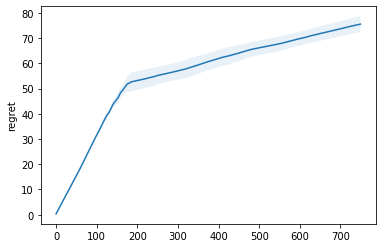

In [70]:
x = regrets.cumsum(axis=-1)
mean_regret = x.mean(axis=0)
std_regret = x.std(axis=0)
plt.plot(mean_regret)
plt.fill_between(np.arange(nb_episodes), mean_regret - std_regret, mean_regret + std_regret, alpha=0.1)
plt.ylabel('regret')

# SAVE PSRL REGRET
ucrl_regret = mean_regret

# Posterior Sampling for RL

At each iteration, PSRL samples one MDP from the posterior distribution and run the associated optimal policy.

Implement posterior sampling

In [0]:
def PSRL(mdp, H, nb_episodes, VSTAR=0):
    reward_prior = [1,1]
    S, A = mdp.Ns, mdp.Na
    Phat = np.ones((S,A,S)) / S
    Rhat = np.zeros((S,A))
    N_sas = np.zeros((S,A,S), dtype=np.int)
    N_sa = np.zeros((S,A), dtype=np.int)
    regret = np.zeros((nb_episodes,))
    
    for k in range(nb_episodes):
        
        # compute policy
        # 1. sample MDP
        R = np.zeros_like(Rhat)
        P = np.zeros((S, A, S))
        for s in range(S):
            for a in range(A):
                # sample transition matrix
                # P[s, a] follows a dirichlet Dirichlet distribution of parameters N_sas[s, a,:] + 1
                P[s, a] = ...

                # posterior for Bernoulli rewards
                N = N_sa[s, a]
                v = N * Rhat[s, a]
                a0 = reward_prior[0] + v
                b0 = reward_prior[1] + N - v
                p = np.random.beta(a=a0, b=b0, size=1).item()
                R[s, a] = p
        
        # 2. compute optimal policy
        V, policy = ...
        
        # execute policy
        initial_state = state = mdp.reset()
        for h in range(H):
            action = policy[h][state]
            next_state, reward, done, _ = mdp.step(action)
            
            # update estimates (Rhat, N_sa, N_sas)
            ...
            
            state = next_state
        
        # update regret
        Vpi = policy_evaluation(mdp.P, mdp.R, H, policy)
        regret[k] = VSTAR[0][initial_state] - Vpi[0][initial_state]
        
        if k % 50 == 0:
            print("regret[{}]: {}".format(k, regret[k]))

    return regret

In [0]:
nb_repetitions = 5
nb_episodes = 750
regrets = np.zeros((nb_repetitions, nb_episodes))
for it in range(nb_repetitions):
    print("Running simulation: {}".format(it))
    regrets[it] = PSRL(mdp=env, H=H, nb_episodes=nb_episodes, VSTAR=Vstar)

In [0]:
x = regrets.cumsum(axis=-1)
mean_regret = x.mean(axis=0)
std_regret = x.std(axis=0)
plt.plot(mean_regret)
plt.fill_between(np.arange(nb_episodes), mean_regret - std_regret, mean_regret + std_regret, alpha=0.1)
plt.ylabel('regret')

# SAVE PSRL REGRET
psrl_regret = mean_regret

Compare algorithms

In [0]:
plt.figure(figsize=(10,8))
plt.plot(ucrl_regret, label='UCRL-H')
plt.plot(psrl_regret, label='PSRL')
plt.legend()